In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
df = pd.read_csv("all-data.csv", encoding='latin1')
df.columns = ["label", "sentence"]

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (4845, 2)


,label,sentence
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
import re

def clean_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['sentence'] = df['sentence'].apply(clean_text)

print("Cleaned sentences examples:")
display(df.head())

Cleaned sentences examples:


,label,sentence
0,neutral,technopolis plans to develop in stages an area...
1,negative,the international electronic industry company ...
2,positive,with the new production plant the company woul...
3,positive,according to the company s updated strategy fo...
4,positive,financing of aspocomp s growth aspocomp is agg...


In [ ]:
label_map = {label: idx for idx, label in enumerate(df["label"].unique())}
df["label_id"] = df["label"].map(label_map)

X_train, X_temp, y_train, y_temp = train_test_split(
    df["sentence"],
    df["label_id"],
    test_size=0.3,
    stratify=df["label_id"],
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=2/3,
    stratify=y_temp,
    random_state=42
)

print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))

Train: 3391
Val: 484
Test: 970


In [ ]:
print(df["label"].value_counts())
print("\nClass ratio:")
print(df["label"].value_counts(normalize=True))

label
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64

Class ratio:
label
neutral     0.594014
positive    0.281321
negative    0.124665
Name: proportion, dtype: float64


In [ ]:
df["length"] = df["sentence"].apply(lambda x: len(x.split()))

print("Mean length:", df["length"].mean())
print("Median length:", df["length"].median())
print("Max length:", df["length"].max())

Mean length: 20.48937048503612
Median length: 19.0
Max length: 52


In [ ]:
def tokenize(text):
    return text.lower().split()

counter = Counter()
for text in X_train:
    counter.update(tokenize(text))

vocab = {"<PAD>":0, "<UNK>":1}
for word in counter:
    vocab[word] = len(vocab)

print("Vocabulary size:", len(vocab))

Vocabulary size: 9169


In [ ]:
def compute_oov(texts):
    total = 0
    oov = 0
    for text in texts:
        for word in tokenize(text):
            total += 1
            if word not in vocab:
                oov += 1
    return oov / total

print("OOV rate (Val):", compute_oov(X_val))

OOV rate (Val): 0.07739938080495357


In [ ]:
MAX_LEN = int(df["length"].mean()) + 10
print("MAX_LEN:", MAX_LEN)

def encode(text):
    tokens = tokenize(text)
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens]
    if len(ids) < MAX_LEN:
        ids += [0]*(MAX_LEN-len(ids))
    else:
        ids = ids[:MAX_LEN]
    return ids

MAX_LEN: 30


In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(encode(self.texts[idx])), torch.tensor(self.labels[idx])

train_ds = TextDataset(X_train, y_train)
val_ds   = TextDataset(X_val, y_val)
test_ds  = TextDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim*2, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden*2)
        energy = torch.tanh(self.attn(lstm_output))
        attention = torch.softmax(self.context(energy), dim=1)
        weighted = lstm_output * attention
        representation = weighted.sum(dim=1)
        return representation

In [ ]:
class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(BiLSTMAttention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        self.attention = Attention(hidden_dim)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        attn_out = self.attention(lstm_out)
        out = self.dropout(attn_out)
        return self.fc(out)

In [ ]:
model = BiLSTMAttention(len(vocab), 100, 128, len(label_map)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 15

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

train_time = time.time() - start_time
print("Training time (seconds):", train_time)

Epoch 1, Loss: 0.8758
Epoch 2, Loss: 0.7309
Epoch 3, Loss: 0.5710
Epoch 4, Loss: 0.4284
Epoch 5, Loss: 0.2960
Epoch 6, Loss: 0.2028
Epoch 7, Loss: 0.1126
Epoch 8, Loss: 0.0744
Epoch 9, Loss: 0.0585
Epoch 10, Loss: 0.0419
Epoch 11, Loss: 0.0210
Epoch 12, Loss: 0.0136
Epoch 13, Loss: 0.0164
Epoch 14, Loss: 0.0407
Epoch 15, Loss: 0.0318
Training time (seconds): 124.36846566200256


In [ ]:
def evaluate(loader):
    model.eval()
    preds, true = [], []

    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            outputs = model(texts)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()

            preds.extend(predictions)
            true.extend(labels.numpy())

    acc = accuracy_score(true, preds)
    macro = f1_score(true, preds, average="macro")
    weighted = f1_score(true, preds, average="weighted")

    return acc, macro, weighted, true, preds

acc, macro, weighted, y_true, y_pred = evaluate(test_loader)

print("Accuracy:", acc)
print("Macro-F1:", macro)
print("Weighted-F1:", weighted)

Accuracy: 0.7298969072164948
Macro-F1: 0.6623295158193784
Weighted-F1: 0.721162208362264


In [ ]:
print(classification_report(y_true, y_pred, target_names=label_map.keys()))

              precision    recall  f1-score   support

     neutral       0.77      0.87      0.81       576
    negative       0.64      0.55      0.59       121
    positive       0.66      0.52      0.58       273

    accuracy                           0.73       970
   macro avg       0.69      0.65      0.66       970
weighted avg       0.72      0.73      0.72       970



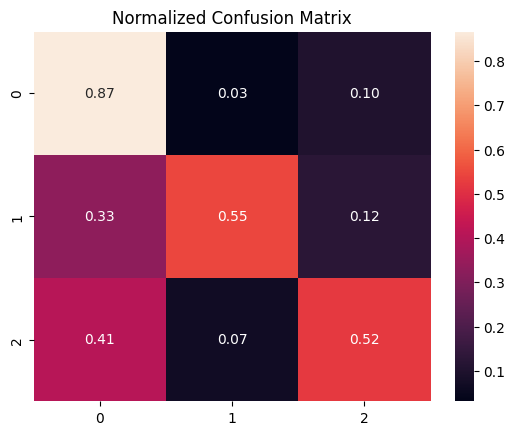

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure()
sns.heatmap(cm, annot=True, fmt=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()

In [ ]:
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024**2)
print("Model size (MB):", model_size)

Model size (MB): 4.525051116943359
